In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_style('white')

%matplotlib inline

In [2]:
df = pd.read_csv('jass-data.csv', index_col=0)
df.head()
df['weight_delta_0_7'] = (df['Wt(g) Day7'] - df['Wt(g) Day0']) / df['Wt(g) Day0']

In [3]:
df.columns

Index(['ID', 'Age', 'Sex', 'Group', 'Day sacrificed', 'Batch', 'Wt(g) Day0',
       'Wt(g) Day1', 'Wt(g) Day2', 'Wt(g) Day3',
       ...
       'absolute_weight_change9_10', 'fractional_weight_change_10_11',
       'absolute_weight_change10_11', 'fractional_weight_change_11_12',
       'absolute_weight_change11_12', 'fractional_weight_change_12_13',
       'absolute_weight_change12_13', 'fractional_weight_change_13_14',
       'absolute_weight_change13_14', 'weight_delta_0_7'],
      dtype='object', length=107)

In [4]:
coinfected = df[df['Group'] == 'Hp+Flu+'].dropna(subset=['weight_delta_0_7'])
coinfected.shape

(72, 107)

In [5]:
flu_only = df[df['Group'] == 'Hp-Flu+'].dropna(subset=['weight_delta_0_7'])
flu_only.shape

(103, 107)

In [6]:
hp_only = df[df['Group'] == 'Hp+Flu-'].dropna(subset=['weight_delta_0_7'])
hp_only.shape

(68, 107)

In [7]:
control = df[df['Group'] == 'Hp-Flu-'].dropna(subset=['weight_delta_0_7'])
control.shape

(91, 107)

We are going to investigate the following questions here:

For weight change from day 0 to day 7:
1. What is the precision in measured weight change for each group of mice?
1. Compared to coinfected mice, what is the precision in the difference when compared to hp-only and flu-only infected mice respectively?

Here, precision refers to the 95% HPD in the posterior distribution.

The model is specified with extremely uninformative priors. 

For **weight change** in each group, we use the separate T-distributions, with improper `Flat` priors for the mean, and `Exponential` priors for the degrees of freedom and coefficients. 

**Differences** between the control and flu-only, and control and hp-only mice, are modelled `Deterministically`, for we still want to know the distribution of differences, just that we have no good way of specifying a prior distribution on it. In the equation below, this difference is notated using the letter `d`.

**Effect sizes** are computed as

    abs(difference) / sqrt((sd_grp1**2 + sd_grp2**2) / 2)
    
where:

- `difference` is the difference between the two groups
- `abs` takes the absolute value of a number
- `sqrt` is the square-root function
- `sd_grpX` is the modelled standard deviation of group X, and
- `**2` squares a number

In [9]:
# Model specification.
with pm.Model() as model:
    nu_coinf = pm.Exponential('nu_coinf', 1/(len(coinfected) - 1)) + 1    
    mu_coinf = pm.Flat('wt_change_coinf')
    sd_coinf = pm.Exponential('sd_coinf', lam=1)
    #coinf_wt = pm.Normal('coinfected weight change', mu=mu_coinf, sd=sd_coinf, 
    #                      observed=coinfected['weight_delta_0_7'].values)
    coinf_wt = pm.StudentT('coinfected weight change',
                           mu=mu_coinf,
                           lam=sd_coinf**-2,
                           nu=nu_coinf,
                           observed=coinfected['weight_delta_0_7'].values)

    nu_flu = pm.Exponential('nu_flu', 1/(len(flu_only) - 1)) + 1    
    mu_flu = pm.Flat('wt_change_flu')
    sd_flu = pm.Exponential('sd_flu', lam=1)
    # flu_wt = pm.Normal('flu-only weight change', mu=mu_flu, sd=sd_flu,
    #                    observed=flu_only['weight_delta_0_7'].values)
    flu_wt = pm.StudentT('flu-only weight change',
                         mu=mu_flu,
                         lam=sd_flu**-2,
                         nu=nu_flu,
                         observed=flu_only['weight_delta_0_7'].values)

    nu_hp = pm.Exponential('nu_hp', 1/(len(hp_only) - 1)) + 1        
    mu_hp = pm.Flat('wt_change_hp')
    sd_hp = pm.Exponential('sd_hp', lam=1)
    # hp_wt = pm.Normal('hp-only weight change', mu=mu_hp, sd=sd_hp,
    #                   observed=hp_only['weight_delta_0_7'].values)
    hp_wt = pm.StudentT('hp-only weight change',
                        mu=mu_hp,
                        lam=sd_hp**-2,
                        nu=nu_hp,
                        observed=hp_only['weight_delta_0_7'].values)

    nu_ctrl = pm.Exponential('nu_ctrl', 1/(len(control) - 1)) + 1        
    mu_ctrl = pm.Flat('wt_change_ctrl')
    sd_ctrl = pm.Exponential('sd_ctrl', lam=1)
    # ctrl_wt = pm.Normal('control weight change', mu=mu_ctrl, sd=sd_ctrl,
    #                     observed=control['weight_delta_0_7'].values)
    ctrl_wt = pm.StudentT('control weight change',
                          mu=mu_ctrl,
                          lam=sd_ctrl**-2,
                          nu=nu_ctrl,
                          observed=control['weight_delta_0_7'].values)


    # ratio_cf = pm.Deterministic('ratio_cf', mu_coinf / mu_flu)  # ratio between coinfected and flu-only
    diff_cf = pm.Deterministic('diff_cf', mu_coinf - mu_flu)
    effect_cf = pm.Deterministic('effect_cf', abs(diff_cf) / pm.sqrt((sd_flu**2 + sd_coinf**2) / 2))
    
    # ratio_ch = pm.Deterministic('ratio_ch', mu_coinf / mu_hp)  # ratio between coinfected and hp-only
    diff_ch = pm.Deterministic('diff_ch', mu_coinf - mu_hp)
    effect_ch = pm.Deterministic('effect_ch', abs(diff_ch) / pm.sqrt((sd_hp**2 + sd_coinf**2) / 2))

Applied log-transform to nu_coinf and added transformed nu_coinf_log_ to model.
Applied log-transform to sd_coinf and added transformed sd_coinf_log_ to model.
Applied log-transform to nu_flu and added transformed nu_flu_log_ to model.
Applied log-transform to sd_flu and added transformed sd_flu_log_ to model.
Applied log-transform to nu_hp and added transformed nu_hp_log_ to model.
Applied log-transform to sd_hp and added transformed sd_hp_log_ to model.
Applied log-transform to nu_ctrl and added transformed nu_ctrl_log_ to model.
Applied log-transform to sd_ctrl and added transformed sd_ctrl_log_ to model.


Because MCMC sampling takes longer, I have opted to use Automatic Differentiation Variational Inference (ADVI) to fit the posterior distributions. Like MCMC, it will return a posterior distribution, it just does it differently.

In [10]:
%%time
with model:
    params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(params, draws=5000)

Iteration 0 [0%]: ELBO = -762.1
Iteration 5000 [10%]: Average ELBO = -585.85
Iteration 10000 [20%]: Average ELBO = -113.74
Iteration 15000 [30%]: Average ELBO = 203.63
Iteration 20000 [40%]: Average ELBO = 463.45
Iteration 25000 [50%]: Average ELBO = 585.53
Iteration 30000 [60%]: Average ELBO = 609.9
Iteration 35000 [70%]: Average ELBO = 612.07
Iteration 40000 [80%]: Average ELBO = 612.07
Iteration 45000 [90%]: Average ELBO = 612.2
Finished [100%]: Average ELBO = 612.09
CPU times: user 28.8 s, sys: 944 ms, total: 29.7 s
Wall time: 44.4 s


Trace plots give us a sense of when the values converged.

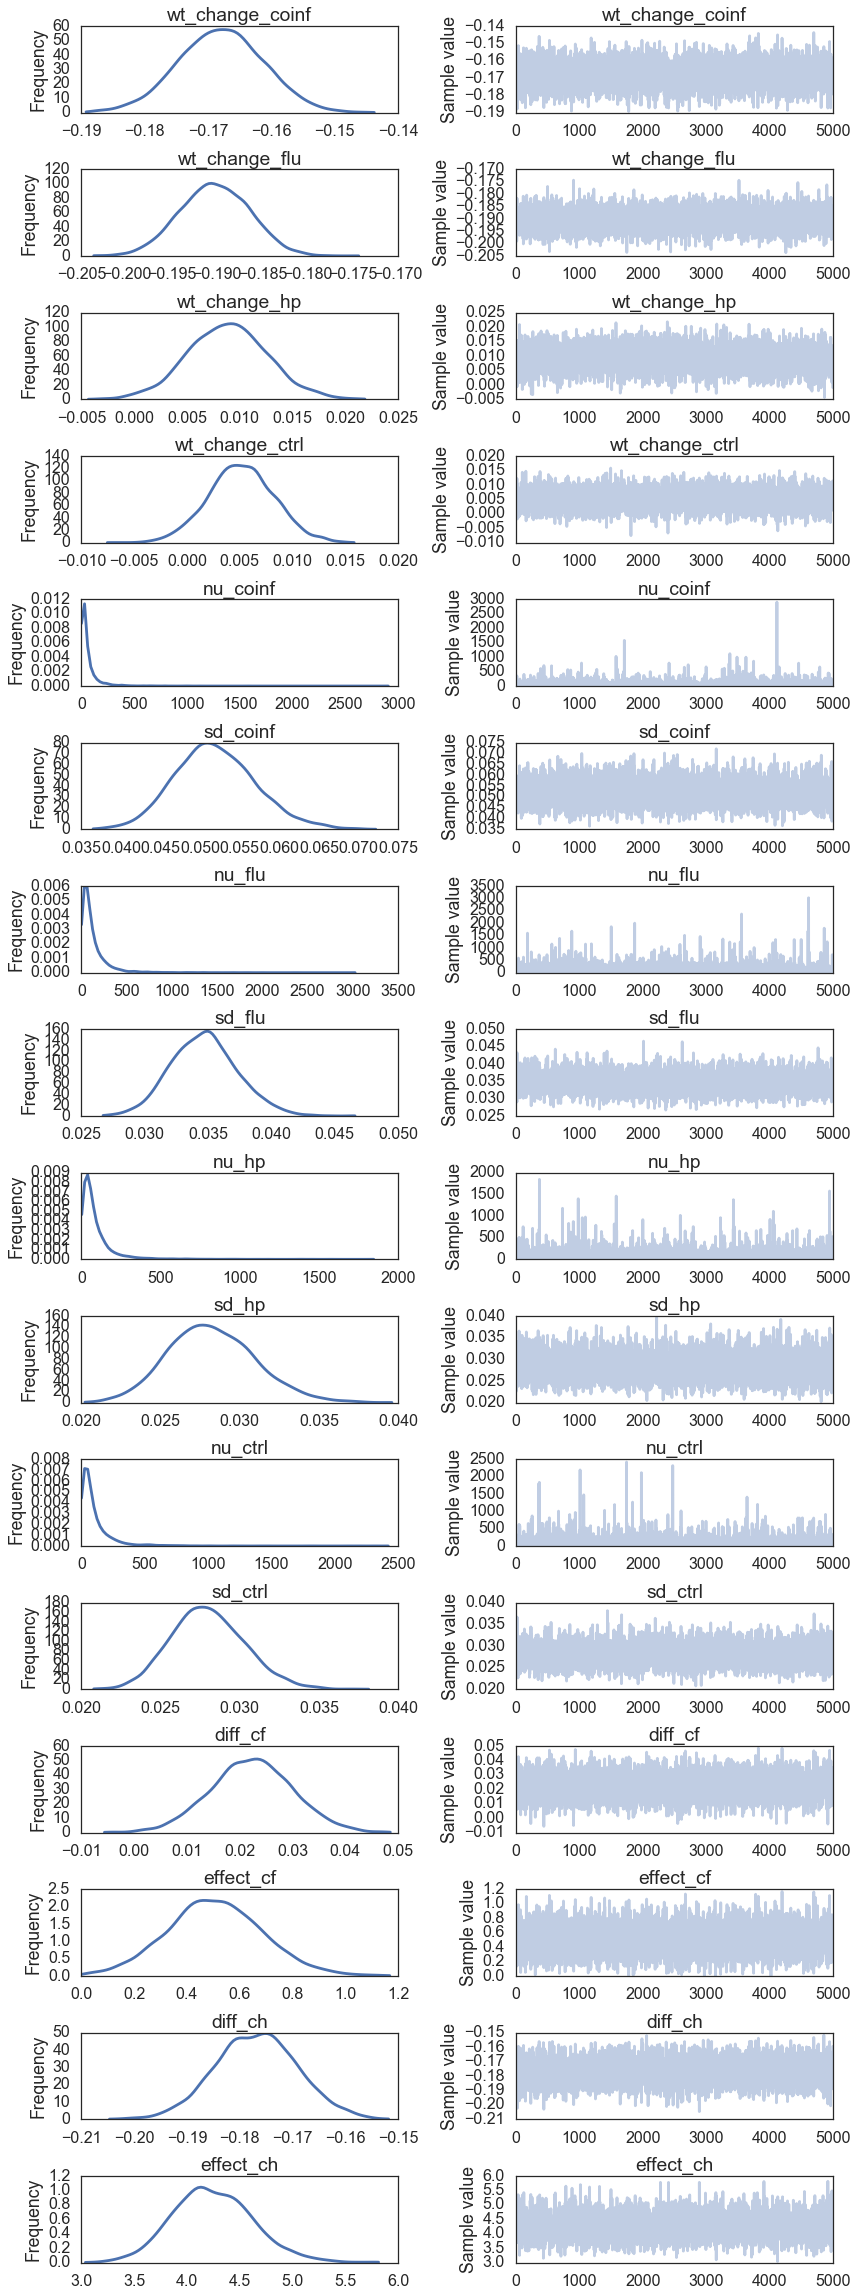

In [11]:
pm.traceplot(trace)
plt.show()

Looking at the plots, they converge early on. Pick a good number - say, 2000 - that will be the chain starting point that we'll sample from.

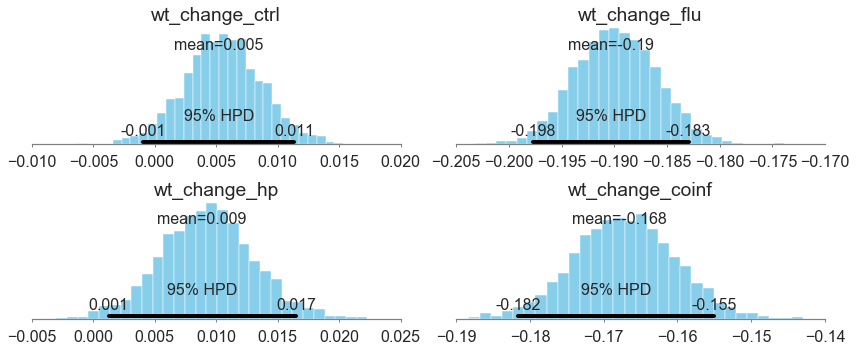

In [12]:
pm.plot_posterior(trace[2000:],
                  varnames=['wt_change_ctrl', 'wt_change_flu', 'wt_change_hp', 'wt_change_coinf'], 
                  color='#87ceeb')
plt.show()

Based on this, we can see that the control group experienced some weight gain from day 0 to day 7, as did the hp-only group. The flu-only group experienced a mean change of approximately -4.2 grams, while the coinfected group experienced a mean change of approximately 3.4 grams. 

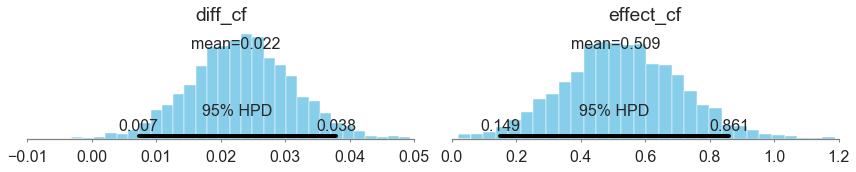

In [13]:
pm.plot_posterior(trace[2000:], varnames=['diff_cf', 'effect_cf'], color='#87ceeb')
plt.show()

The flu-only mice lost 2% more weight than the control mice. Not very much protection from this standpoint. Also, the effect size ranges from small to moderate.

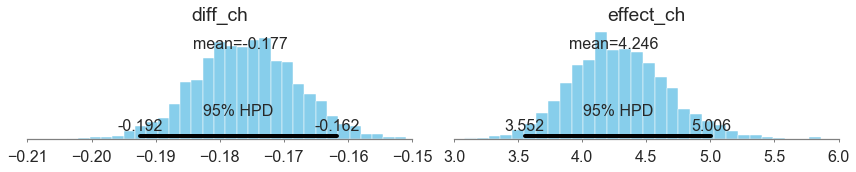

In [14]:
pm.plot_posterior(trace[2000:], varnames=['diff_ch', 'effect_ch'], color='#87ceeb')
plt.show()

The coinfected mice lost more weight than the HP-only mice, and the effect size is computed as approx. 4.3. This is a very high effect size.

Taken together, I interpret this data as saying that hp-infection produces a small degree of protection against flu infection.

Compare this to a T-test:

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind(a=coinfected['weight_delta_0_7'], b=flu_only['weight_delta_0_7'])

In [ ]:
ttest_ind(a=coinfected['weight_delta_0_7'], b=hp_only['weight_delta_0_7'])